# TorchVision Faster R-CNN Inference

## Prepare Data

- [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection)
- [TorchVision Faster R-CNN Finetuning](https://www.kaggle.com/gocoding/torchvision-faster-r-cnn-finetuning)

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/torchvision-faster-r-cnn-finetuning'
WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'

### Submission File

The submission format requires a space delimited set of bounding boxes. For example:

`ce4833752,0.5 0 0 100 100`

indicates that image `ce4833752` has a bounding box with a confidence of `0.5`, at `x` == 0 and `y` == 0, with a `width` and `height` of 100.

In [2]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.tail()

,image_id,PredictionString
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


### Create Dataset

In [3]:
import cv2 as cv
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset


class WheatTest(Dataset):

  def __init__(self, image_ids, image_dir, transforms=None):
    super().__init__()
    self.image_ids = image_ids
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    if self.transforms:
      sample = {
        'image': image,
      }
      sample = self.transforms(**sample)
      image = sample['image']

    return image, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  @staticmethod
  def get_test_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ])

### Create DataLoader

In [4]:
def get_image_ids(p):
  import glob
  image_ids = []
  for p in glob.glob(f'{p}/*.jpg'):
    n, _ = os.path.splitext(os.path.basename(p))
    image_ids.append(n)
  return image_ids

# try more images for submission
#test_dataset = WheatTest(get_image_ids(DIR_TRAIN), DIR_TRAIN, WheatTest.get_test_transform())

test_dataset = WheatTest(test_df["image_id"].unique(), DIR_TEST, WheatTest.get_test_transform())

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  return tuple(zip(*batch))

test_data_loader = DataLoader(
  test_dataset,
  batch_size=8, # GPU not enough if inference 16 images
  shuffle=False,
  num_workers=4,
  drop_last=False,
  collate_fn=collate_fn
)

## Load Model

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# create a Faster R-CNN model without pre-trained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = 2 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
model.eval()

# move model to the right device
_ = model.to(device)

## Let's Inference

In [7]:
score_threshold = 0.7
image_outputs = []

for images, image_ids in test_data_loader:
  images = list(image.to(device) for image in images)
  outputs = model(images)
    
  for image_id, output in zip(image_ids, outputs):
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask].astype(np.int32)
    scores = scores[mask]

    image_outputs.append((image_id, boxes, scores))

### Show Outputs

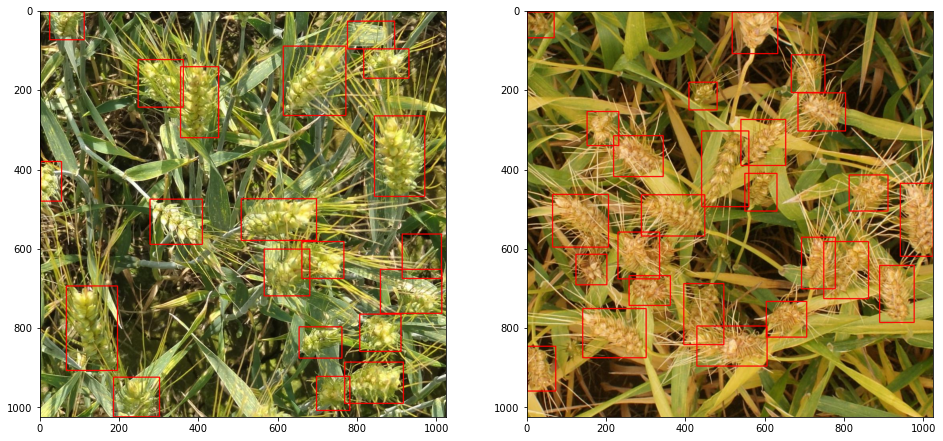

In [8]:
num_rows, num_cols = 1, 2
scale = 16
figsize = (num_rows * scale, num_cols * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

fig_n = num_rows * num_cols
fig_i = 0

for i in range(1, 1+fig_n):
  image, image_id = test_dataset[i]
  _, boxes, scores = image_outputs[i]

  sample = image.permute(1, 2, 0).cpu().numpy()

  for box in boxes:
    cv.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 2)

  axes[fig_i].imshow(sample)
  fig_i += 1

### Save Results

In [9]:
def format_prediction_string(boxes, scores):
  pred_strings = []
  for score, box in zip(scores, boxes):
    pred_strings.append(round(score, 4))
    pred_strings.extend(box)
  return ' '.join(map(str, pred_strings))

results = []

for image_id, boxes, scores in image_outputs:
  #boxes = boxes_.copy()
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

  result = {
    'image_id': image_id,
    'PredictionString': format_prediction_string(boxes, scores)
  }
  results.append(result)

results[0]

{'image_id': 'aac893a91',
 'PredictionString': '0.994 557 536 122 185 0.9927 69 5 101 159 0.9873 617 919 76 104 0.9867 333 671 111 148 0.9855 28 460 103 151 0.9839 741 773 79 116 0.9837 820 710 105 198 0.9813 588 780 96 118 0.979 175 570 113 184 0.9771 696 395 116 180 0.9723 357 534 94 81 0.9689 459 864 81 90 0.9453 550 59 137 199 0.9422 246 97 128 134 0.941 305 0 73 68 0.9219 237 844 156 108 0.8985 94 620 113 89 0.8535 65 860 112 72 0.846 827 630 82 121 0.7194 166 7 77 144'}

In [10]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,aac893a91,0.994 557 536 122 185 0.9927 69 5 101 159 0.98...
1,51f1be19e,0.9833 277 474 132 114 0.982 613 88 158 175 0....
2,f5a1f0358,0.9898 539 273 113 116 0.9864 889 641 87 144 0...
3,796707dd7,0.9837 898 335 108 90 0.968 505 791 93 95 0.96...
4,51b3e36ab,0.9975 3 440 97 322 0.9936 234 648 96 156 0.99...
5,348a992bb,0.9914 4 317 117 99 0.99 737 221 138 89 0.9891...
6,cc3532ff6,0.9933 766 837 168 161 0.9917 492 581 97 130 0...
7,2fd875eaa,0.9929 458 506 82 129 0.9917 468 354 118 95 0....
8,cb8d261a3,0.9881 307 163 115 206 0.9831 21 867 81 143 0....
9,53f253011,0.996 931 205 93 133 0.9959 469 472 157 193 0....


In [11]:
test_df.to_csv('submission.csv', index=False)